# Problem 4 - Siamese Network for Face Recognition

Code source: https://colab.research.google.com/github/maticvl/dataHacker/blob/master/pyTorch/014_siameseNetwork.ipynb#scrollTo=OFLiEonUv5cv

## 4.1

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [52]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [53]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [54]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2023-11-07 01:29:03--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2023-11-07 01:29:04--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip.1’

at&t.zip.1          100%[===================>]   3.62M  --.-KB/s    in 0.08s   

2023-11-07 01:29:04 (48.2 MB/s) - ‘at&t.zip.1’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creatin

In [55]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [56]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

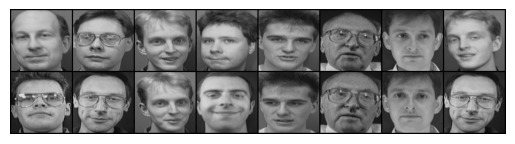

[1. 1. 0. 1. 0. 0. 0. 1.]


In [57]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

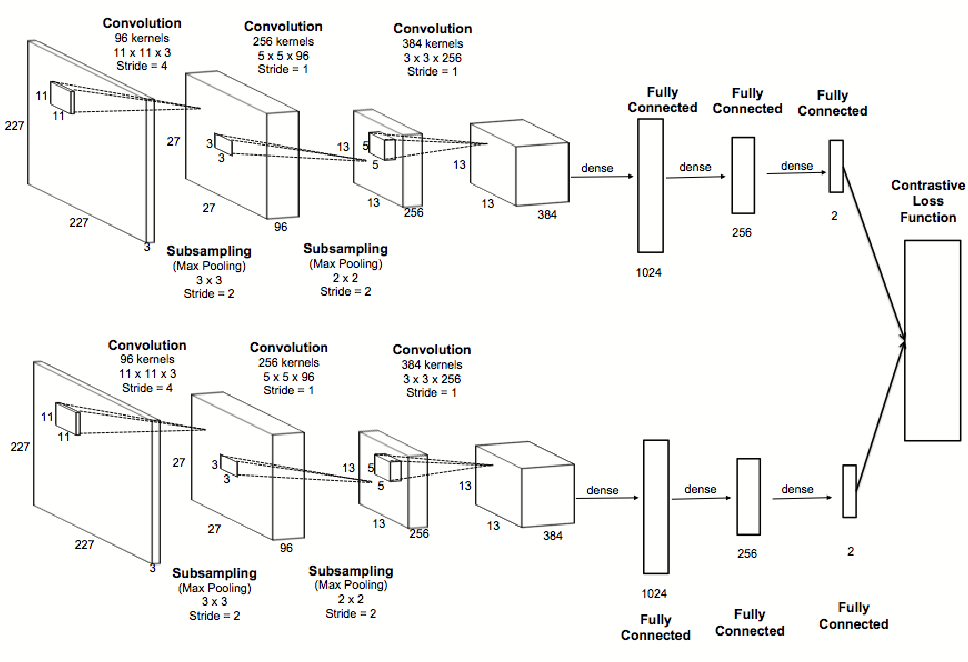

In [58]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

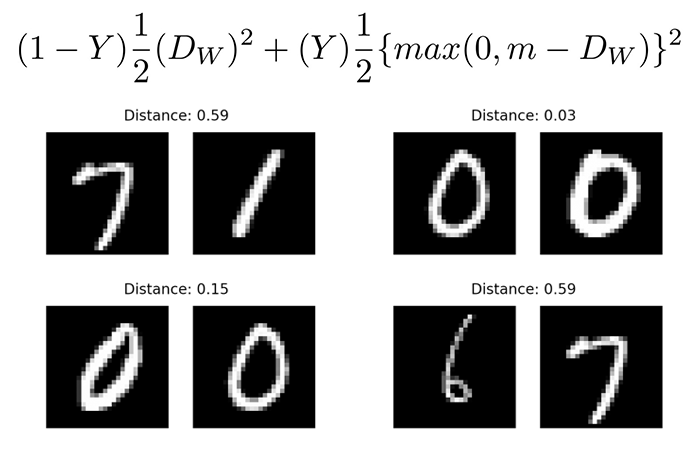

In [59]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [60]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [62]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

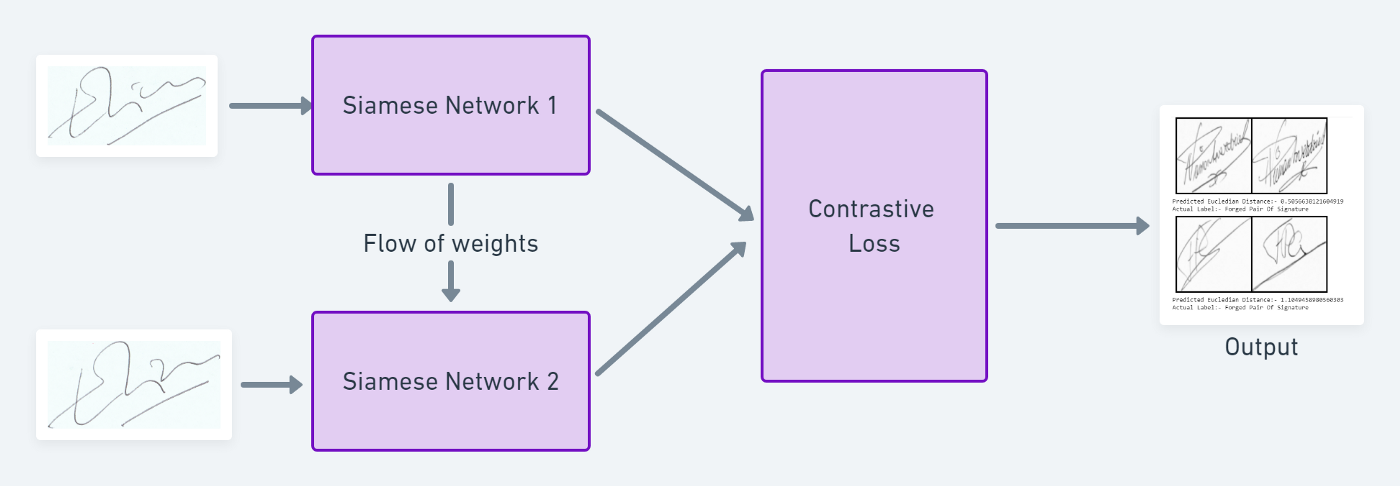

Epoch number 0
 Current loss 2.3085474967956543

Epoch number 1
 Current loss 1.0500030517578125

Epoch number 2
 Current loss 0.7022794485092163

Epoch number 3
 Current loss 1.0373239517211914

Epoch number 4
 Current loss 0.5625309944152832

Epoch number 5
 Current loss 0.662798285484314

Epoch number 6
 Current loss 0.7720010280609131

Epoch number 7
 Current loss 0.4577487111091614

Epoch number 8
 Current loss 0.5442373156547546

Epoch number 9
 Current loss 0.5665696263313293

Epoch number 10
 Current loss 0.6380552053451538

Epoch number 11
 Current loss 0.461372971534729

Epoch number 12
 Current loss 0.3454078435897827

Epoch number 13
 Current loss 0.49979907274246216

Epoch number 14
 Current loss 0.3312622606754303

Epoch number 15
 Current loss 0.3880850374698639

Epoch number 16
 Current loss 0.27789759635925293

Epoch number 17
 Current loss 0.33553463220596313

Epoch number 18
 Current loss 0.5711181163787842

Epoch number 19
 Current loss 0.3731462359428406

Epoch num

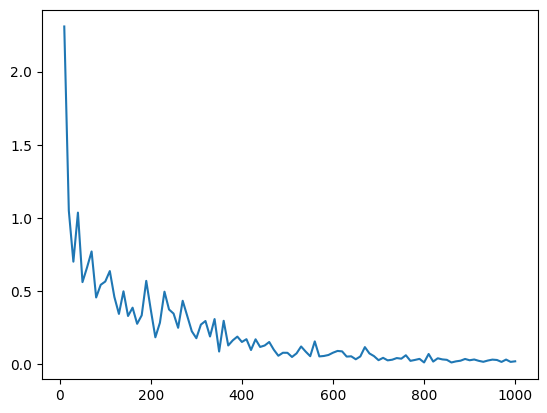

In [63]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

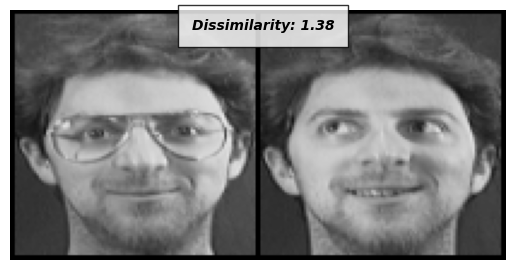

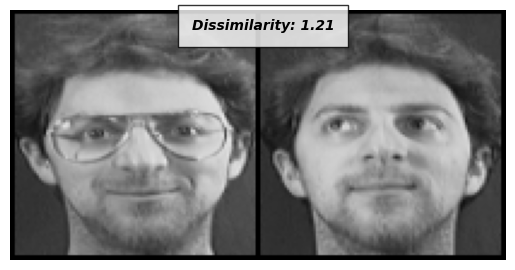

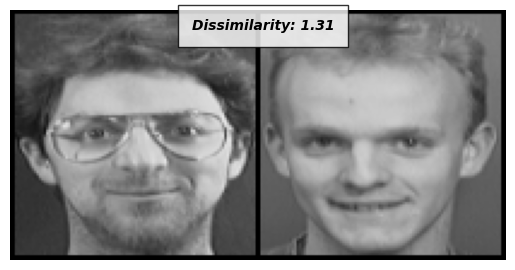

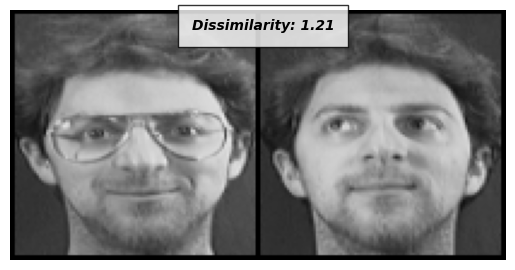

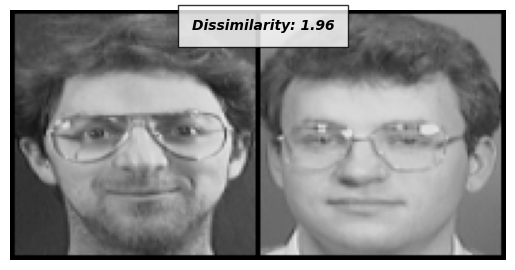

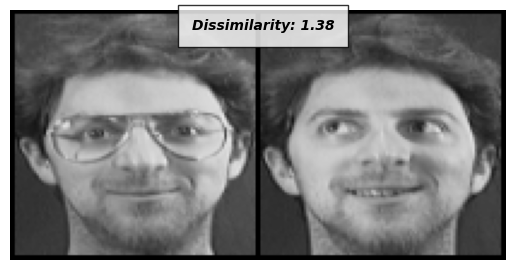

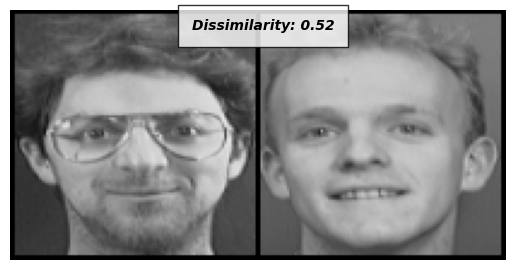

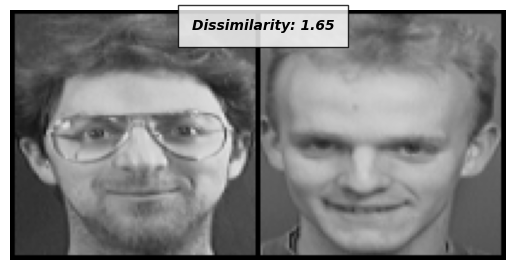

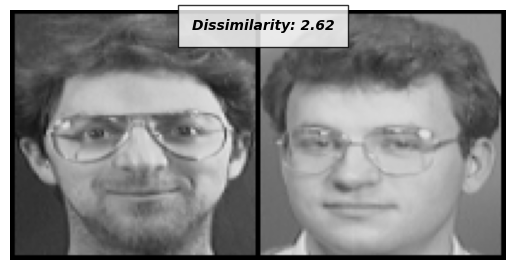

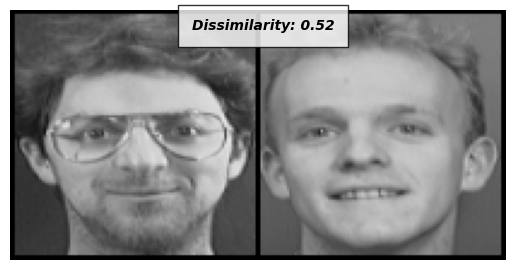

In [64]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

Above we have trained and evaluated the Siamese network model from the given notebook.

## 4.2

In [68]:
from sklearn.metrics import accuracy_score # To evaluate accuracy of our threshold

def determine_threshold(net, dataloader):
    net.eval()

    distances = []
    labels = []

    with torch.no_grad():
        for i, (img0, img1, label) in enumerate(dataloader):
            output1, output2 = net(img0.cuda(), img1.cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            distances.extend(euclidean_distance.cpu().numpy())
            labels.extend(label.cpu().numpy())

    # Convert to numpy arrays for convenience
    distances = np.array(distances).flatten()
    labels = np.array(labels).flatten()

    # Define a range of potential thresholds
    thresholds = np.linspace(0, 5, 100) #we don't have to go over 5 since we saw above those faces do not look alike at all

    # Finding the threshold that maximizes accuracy
    best_threshold = 0
    best_accuracy = 0
    for thresh in thresholds:
        predictions = (distances > thresh).astype(int)
        current_accuracy = accuracy_score(labels, predictions)
        print(f"Threshold: {thresh:.4f} - Accuracy: {current_accuracy:.4f}")
        if current_accuracy >= best_accuracy:
            best_accuracy = current_accuracy
            best_threshold = thresh

    return best_threshold, best_accuracy

# Get the optimal threshold and accuracy
threshold, best_accuracy = determine_threshold(net, train_dataloader)
print(f"Optimal threshold: {threshold:.4f}")
print(f"Optimal accuracy: {best_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Threshold: 0.0000 - Accuracy: 0.5108
Threshold: 0.0505 - Accuracy: 0.5838
Threshold: 0.1010 - Accuracy: 0.6865
Threshold: 0.1515 - Accuracy: 0.7541
Threshold: 0.2020 - Accuracy: 0.8270
Threshold: 0.2525 - Accuracy: 0.8811
Threshold: 0.3030 - Accuracy: 0.9054
Threshold: 0.3535 - Accuracy: 0.9459
Threshold: 0.4040 - Accuracy: 0.9676
Threshold: 0.4545 - Accuracy: 0.9865
Threshold: 0.5051 - Accuracy: 0.9892
Threshold: 0.5556 - Accuracy: 0.9919
Threshold: 0.6061 - Accuracy: 0.9919
Threshold: 0.6566 - Accuracy: 0.9946
Threshold: 0.7071 - Accuracy: 0.9946
Threshold: 0.7576 - Accuracy: 0.9946
Threshold: 0.8081 - Accuracy: 0.9973
Threshold: 0.8586 - Accuracy: 1.0000
Threshold: 0.9091 - Accuracy: 1.0000
Threshold: 0.9596 - Accuracy: 1.0000
Threshold: 1.0101 - Accuracy: 1.0000
Threshold: 1.0606 - Accuracy: 1.0000
Threshold: 1.1111 - Accuracy: 1.0000
Threshold: 1.1616 - Accuracy: 1.0000
Threshold: 1.2121 - Accuracy: 1.0000
Threshold: 1.2626 - Accuracy: 1.0000
Threshold: 1.3131 - Accuracy: 1.0000
T

**Answer:**

We have looped over all the potential thresholds and calculated accuracy for each one. We can notice that for thresholds from 0.8586 to 1.3131 our accuracy is 100%. I have choosen to keep the highest threshold with highest accuracy so our optimal threshold will be 1.3131. One thing to note is that these high accuracies are most likely due to overfitting as we are doing the evaluation on our training set and not the test or validation set.

## 4.3

In [70]:
# Function to merge file contents
def merge_files(file_list):
    merged_content = []
    for file_name in file_list:
        with open(file_name, 'r') as file:
            merged_content.extend(file.readlines())
    return merged_content

# Merge the files containing image names with and without glasses (merge probe and gallery to create a larget test set)
gallery_black_glass_content = merge_files(['gallery_black_glass.txt', 'probe_black_glass.txt'])
gallery_no_glass_content = merge_files(['gallery_no_glass.txt', 'probe_no_glass.txt'])

# Parse the image file names and cross-pair them - each with is paired with each without glasses image
def cross_pair_images(names_with_glasses, names_without_glasses):
    # Create dictionaries to hold the image names
    images_with_glasses = {}
    images_without_glasses = {}

    # Process the images with glasses
    for name in names_with_glasses:
        person_id = name.split('@')[0]
        images_with_glasses.setdefault(person_id, []).append(name.strip())

    # Process the images without glasses
    for name in names_without_glasses:
        person_id = name.split('@')[0]
        images_without_glasses.setdefault(person_id, []).append(name.strip())

    # Create cross pairs for images with and without glasses for the same identity/person
    cross_paired_test_set = []
    for person_id, with_glasses_names in images_with_glasses.items():
        without_glasses_names = images_without_glasses.get(person_id, [])
        for name_with in with_glasses_names:
            for name_without in without_glasses_names:
                cross_paired_test_set.append((name_with, name_without))

    return cross_paired_test_set

# Create the test set with cross paired images
test_set_with_vs_without_glasses = cross_pair_images(gallery_black_glass_content, gallery_no_glass_content)

# Example usage: print the first few pairs
for pair in test_set_with_vs_without_glasses[:5]: #just showing the names not images
    print(pair)


('69072483@N00_identity_2@1440008490_0.jpg', '69072483@N00_identity_2@410787454_0.jpg')
('69072483@N00_identity_2@1440008490_0.jpg', '69072483@N00_identity_2@1440010488_0.jpg')
('69072483@N00_identity_2@1588090195_0.jpg', '69072483@N00_identity_2@410787454_0.jpg')
('69072483@N00_identity_2@1588090195_0.jpg', '69072483@N00_identity_2@1440010488_0.jpg')
('39442289@N00_identity_8@3343113052_0.jpg', '39442289@N00_identity_8@4891147504_1.jpg')


In [73]:
# Unzipping the file
import zipfile
import os

# Unzip the MeGlass_120x120.zip
#with zipfile.ZipFile("MeGlass_120x120.zip", 'r') as zip_ref:
#    zip_ref.extractall("MeGlass_120x120")

In [75]:
# Path to the unzipped image directory
image_dir = "MeGlass_120x120/MeGlass_120x120"

# Function to load images directly
def load_image(image_name, transformation):
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)
    image = image.convert("L")  # Convert to grayscale
    image = transformation(image)
    return image

# Function to evaluate out model
def evaluate_model(test_set, model, transformation, threshold):
    net.eval()  # Set the model to evaluation mode
    similarities = []
    labels = []

    with torch.no_grad():  # No need to track gradients for evaluation
        for img_path_with, img_path_without in test_set:
            img_with = load_image(img_path_with, transformation)
            img_without = load_image(img_path_without, transformation)
            img_with, img_without = img_with.cuda(), img_without.cuda()
            # Add a batch dimension (model expects batches)
            img_with = img_with.unsqueeze(0)
            img_without = img_without.unsqueeze(0)

            output1, output2 = net(img_with, img_without)
            euclidean_distance = F.pairwise_distance(output1, output2).item()
            similarities.append(euclidean_distance)
            labels.append(0)  # Same person

    # Calculate accuracy based on the threshold
    predictions = [1 if dist > threshold else 0 for dist in similarities]
    accuracy = accuracy_score(labels, predictions)
    return accuracy

# Perform the evaluation and get the number of missing images
accuracy = evaluate_model(test_set_with_vs_without_glasses, net, transformation, threshold)
print(f"Accuracy of the model on the test set: {accuracy:.4f}")

Accuracy of the model on the test set: 0.0494


**Answer:**

As suspected out model does not do even closely as well on testing data as it did on the training data. In above code we can see that when testing the accuracy of the model on the new, previously unseen, testing data our accuracy is bellow 5% at 4.94%. This means our model does not generalize well on new data.

## 4.4

Paper by Guo et al reference: https://arxiv.org/pdf/1806.01196.pdf

In [76]:
# Lets define Mining-Contrastive loss as defined in Section 3.2 of the paper by Guo et al
class MiningContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(MiningContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the cosine similarity
        cos_sim = F.cosine_similarity(output1, output2)

        # Calculate losses for positive and negative pairs
        pos_loss = label * (1 - cos_sim)
        neg_loss = (1 - label) * F.relu(cos_sim - self.margin)

        # Combine losses
        loss = pos_loss + neg_loss
        return loss.mean()


In [77]:
# Initialize the Siamese Network and the Mining-Contrastive Loss
net = SiameseNetwork().cuda()
criterion = MiningContrastiveLoss(margin=1.0)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

# Training loop
for epoch in range(0, 100):
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Loss: 7.330812513828278e-05
Epoch: 1, Loss: 1.818494638428092e-06
Epoch: 2, Loss: 2.028536982834339e-08
Epoch: 3, Loss: 1.5745172277092934e-08
Epoch: 4, Loss: 3.055902197957039e-08
Epoch: 5, Loss: 1.3795215636491776e-08
Epoch: 6, Loss: 1.3707904145121574e-08
Epoch: 7, Loss: 1.9659637473523617e-08
Epoch: 8, Loss: 1.2165401130914688e-08
Epoch: 9, Loss: 1.2980308383703232e-08
Epoch: 10, Loss: 1.1423253454267979e-08
Epoch: 11, Loss: 1.6210833564400673e-08
Epoch: 12, Loss: 1.3926182873547077e-08
Epoch: 13, Loss: 9.98261384665966e-09
Epoch: 14, Loss: 1.201988197863102e-08
Epoch: 15, Loss: 1.1175870895385742e-08
Epoch: 16, Loss: 1.2965756468474865e-08
Epoch: 17, Loss: 1.1175870895385742e-08
Epoch: 18, Loss: 7.916241884231567e-09
Epoch: 19, Loss: 1.1670636013150215e-08
Epoch: 20, Loss: 1.4872057363390923e-08
Epoch: 21, Loss: 7.043126970529556e-09
Epoch: 22, Loss: 1.3460521586239338e-08
Epoch: 23, Loss: 8.381903171539307e-09
Epoch: 24, Loss: 1.2048985809087753e-08
Epoch: 25, Loss: 1.3

In [79]:
def determine_threshold(net, dataloader):
    net.eval()  # Make sure the network is in eval mode

    cos_sims = []
    labels = []

    with torch.no_grad():
        for img0, img1, label in dataloader:
            img0, img1 = img0.cuda(), img1.cuda()
            output1, output2 = net(img0, img1)
            cos_sim = F.cosine_similarity(output1, output2)
            cos_sims.extend(cos_sim.cpu().numpy())
            labels.extend(label.cpu().numpy())

    labels = np.array(labels)
    cos_sims = np.array(cos_sims)

    # Find the best threshold
    best_accuracy = 0
    best_threshold = 0
    for threshold in np.linspace(0, 5, num=100):
        predictions = (cos_sims > threshold).astype(int)
        accuracy = accuracy_score(labels, predictions)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy

# After training, determine the best threshold
threshold, accuracy = determine_threshold(net, train_dataloader)
print(f"Best Threshold: {threshold}")
print(f"Best Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Best Threshold: 1.0101010101010102
Best Accuracy: 0.5324324324324324


**Answer:**

We can notice that for this model our threshold is slightly lower at 1.01, but our accuracy is significantly lower at 0.53 (53%). This means that our model with Mining-Contrastive loss is most likely overfitting less (or potentially not at all) than our original model with Contrastive Loss.

## 4.5

In [82]:
# Define the path to the unzipped image directory
image_dir = "MeGlass_120x120/MeGlass_120x120"

# Modify the load_image function to load images directly
def load_image(image_name, transformation):
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)
    image = image.convert("L")  # Convert to grayscale
    image = transformation(image)
    return image

# Update the evaluate_model function to skip missing images and count them
def evaluate_model(test_set, model, transformation, threshold):
    net.eval()  # Set the model to evaluation mode
    similarities = []
    labels = []  # Since we're comparing same person, label will always be 0

    with torch.no_grad():  # No need to track gradients for evaluation
        for img_path_with, img_path_without in test_set:
            img_with = load_image(img_path_with, transformation)
            img_without = load_image(img_path_without, transformation)
            img_with, img_without = img_with.cuda(), img_without.cuda()
            # Add a batch dimension (model expects batches)
            img_with = img_with.unsqueeze(0)
            img_without = img_without.unsqueeze(0)

            output1, output2 = net(img_with, img_without)
            euclidean_distance = F.pairwise_distance(output1, output2).item()
            similarities.append(euclidean_distance)
            labels.append(0)  # Same person

    # Calculate accuracy based on the threshold
    predictions = [1 if dist > threshold else 0 for dist in similarities]
    accuracy = accuracy_score(labels, predictions)
    return accuracy

# Perform the evaluation and get the number of missing images
accuracy = evaluate_model(test_set_with_vs_without_glasses, net, transformation, threshold)
print(f"Accuracy of the model on the test set: {accuracy:.4f}")

Accuracy of the model on the test set: 0.4955


**Answer:**

When evaluating our second model with Mining-Contrastive loss on our testing data from MeGlass_120x120 we can see that the accuracy rose tremendously, to 0.4955 (49.55%)  compared to the first model with Constrastive Loss since our original accuracy was 0.0494. Further we can notice that our accuracy on test set is only slightly lower than the accuracy on the training set which would indicate that our model is not overfitting (or minimally overfitting) to the training set data. While we still might not be overly happy with our accuracy since it is only around 50%, it is still significantly better than our original 5% accuracy.


From this we could conclude that using Mining-Contrastive loss not only increases accuracy but also significantly prevents overfitting.